# Prostate Cancer
The data for this example, displayed in Figure 1.11, come from a study by Stamey et al. (1989) that examined the correlation between the level of prostate specific antigen (PSA) and a number of clinical measures, in 97 men who were about to receive a radical prostatectomy.

The goal is to predict the log of PSA (lpsa) from a number of measurements including log cancer volume (lcavol), log prostate weight lweight, age, log of benign prostatic hyperplasia amount lbph, seminal vesicle invasion svi, log of capsular penetration lcp, Gleason score gleason, and percent of Gleason scores 4 or 5 pgg45. Figure 1.1 is a scatterplot matrix of the variables. Some correlations with lpsa are evident, but a good predictive model is difficult to construct by eye.

This is a supervised learning problem, known as a regression problem, because the outcome measurement is quantitative. (PAGE 3)

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# load training and test data set from file
df = pd.read_csv("../data/Prostate Cancer.txt")
target = ['lpsa']
features = ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45']

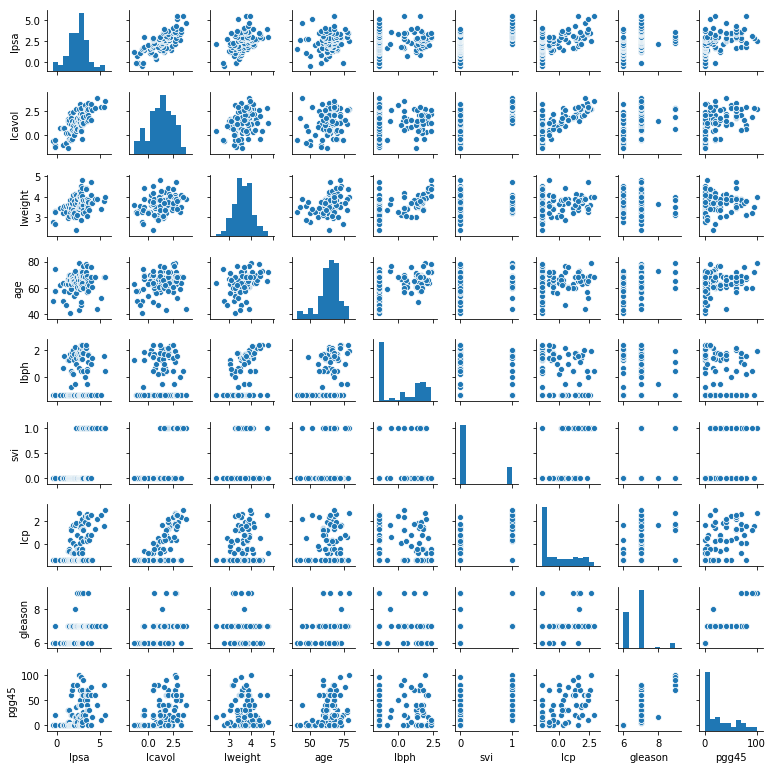

In [3]:
# PAGE 3. FIGURE 1.1. Scatterplot matrix of the prostate cancer data. The first row shows
#         the response against each of the predictors in turn. Two of the predictors, svi and
#         gleason, are categorical.
sns.pairplot(df, vars=target+features, kind="scatter", height=1.2)

In [4]:
# split data to training/test np.arrays
df_train = df[df.train == 'T']
df_test = df[df.train == 'F']
X_train, y_train = df_train[features].values, df_train[target].values
X_test, y_test = df_test[features].values, df_test[target].values

In [5]:
# PAGE 49. The correlation matrix of the predictors given in Table 3.1 shows many
#          strong correlations. Figure 1.1 (page 3) of Chapter 1 is a scatterplot matrix
#          showing every pairwise plot between the variables. We see that svi is a
#          binary variable, and gleason is an ordered categorical variable. We see, for
#          example, that both lcavol and lcp show a strong relationship with the
#          response lpsa, and with each other. We need to fit the effects jointly to
#          untangle the relationships between the predictors and the response.
df[df.train == 'T'][features].corr()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
lcavol,1.000000,0.300232,0.286324,0.063168,0.592949,0.692043,0.426414,0.483161
lweight,0.300232,1.000000,0.316723,0.437042,0.181054,0.156829,0.023558,0.074166
age,0.286324,0.316723,1.000000,0.287346,0.128902,0.172951,0.365915,0.275806
lbph,0.063168,0.437042,0.287346,1.000000,-0.139147,-0.088535,0.032992,-0.030404
svi,0.592949,0.181054,0.128902,-0.139147,1.000000,0.671240,0.306875,0.481358
lcp,0.692043,0.156829,0.172951,-0.088535,0.671240,1.000000,0.476437,0.662533
gleason,0.426414,0.023558,0.365915,0.032992,0.306875,0.476437,1.000000,0.757056
pgg45,0.483161,0.074166,0.275806,-0.030404,0.481358,0.662533,0.757056,1.000000


## Base Error Rate

In [6]:
# PAGE 51. prediction using the mean training value of lpsa has
#          a test error of 1.057, which is called the "base error rate".
base_error_rate = mean_squared_error(y_test, np.full(y_test.shape, np.mean(y_train)))
print(f'Baseline MSE: {base_error_rate:.3f}')

Baseline MSE: 1.057


## Least Squares

In [7]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

C:\Python64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [8]:
# PAGE 50. We fit a linear model to the log of prostate-specific antigen, lpsa, after
#          first standardizing the predictors to have unit variance.
scaler = StandardScaler().fit(np.vstack([X_train, X_test]))
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# PAGE 50. We applied least squares estimation to the training set, producing the estimates,
#          standard errors and Z-scores shown in Table 3.2. 
ls = sm.OLS(y_train, sm.add_constant(X_train)).fit()
ls_params = ls.params

# PAGE 50.   TABLE 3.2. Linear model fit to the prostate cancer data. The Z score (t value) is the
#            coefficient divided by its standard error (3.12). Roughly Z score larger than two 
#            in absolute value is significantly nonzero at the p = 0.05 level.
result = zip(['Intercept'] + features, ls_params, ls.bse, ls.tvalues)
print('      Term   Coefficient   Std. Error   Z Score')
print('-----------------------------------------------')
for term, coefficient, std_err, z_score in result:
    print(f'{term:>10}   {coefficient:>11.2f}   {std_err:>10.2f}  {z_score:>8.2f}')

      Term   Coefficient   Std. Error   Z Score
-----------------------------------------------
 Intercept          2.46         0.09     27.60
    lcavol          0.68         0.13      5.37
   lweight          0.26         0.10      2.75
       age         -0.14         0.10     -1.40
      lbph          0.21         0.10      2.06
       svi          0.30         0.12      2.47
       lcp         -0.29         0.15     -1.87
   gleason         -0.02         0.14     -0.15
     pgg45          0.27         0.15      1.74


In [10]:
# PAGE 51. The mean prediction error on the test data is 0.521.
ls_error_rate = mean_squared_error(np.squeeze(y_test), 
                                   ls.predict(sm.add_constant(X_test)))
print(f'Least Squares MSE: {ls_error_rate:.3f}')

Least Squares MSE: 0.521


#### Least Squares Std Error

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, KFold

In [12]:
# PAGE 62. The estimates of prediction error and their standard errors were obtained by 
#          tenfold cross-validation
cv_mse = -cross_validate(LinearRegression(), X_train, y_train, cv=10,
                         scoring='neg_mean_squared_error', return_train_score=True)['test_score']
ls_std_error = np.std(cv_mse, ddof=1)/np.sqrt(10)
# our result is little bit different, the book has 0.179 (WHY?)
print(f'Least Squares Std Error: {ls_std_error:.3f}')

Least Squares Std Error: 0.174


## Ridge Regression

In [13]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold

In [14]:
K = 10
parameters = {'alpha': [1e20, 436, 165, 82, 44, 23, 12, 4, 1e-05]}
grid_search = GridSearchCV(Ridge(), parameters, 
                           cv=K, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           iid=True)
grid_search.fit(X_train, y_train)
cv = -np.vstack([grid_search.cv_results_[f'split{i}_test_score'] for i in range(K)]).T
rd_errs = np.mean(cv, axis=1)
rd_stde = np.std(cv, ddof=1, axis=1)/np.sqrt(K)

In [15]:
best_dof = np.argmin(rd_errs)
min_err, min_err_stde = rd_errs[best_dof], rd_stde[best_dof]
selected_dof = np.argmax(rd_errs < (min_err + min_err_stde))

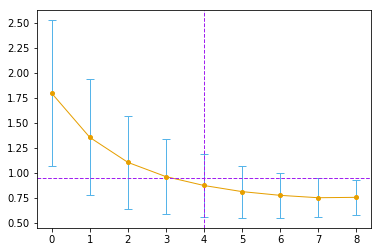

In [16]:
ORANGE, BLUE, PURPLE = '#E69F00', '#56B4E9', '#A020F0'
plt.plot(range(9), rd_errs, c=ORANGE, linewidth=1)
plt.errorbar(range(9), rd_errs,
             color=ORANGE, linestyle='None', marker='o', elinewidth=1,
             markersize=4, yerr=rd_stde, ecolor=BLUE, capsize=4)
plt.axhline(y=min_err+min_err_stde, c=PURPLE, linewidth=1, linestyle='--')
plt.axvline(x=selected_dof, c=PURPLE, linewidth=1, linestyle='--')

In [17]:
selected_dof = 5
rd = Ridge(alpha=parameters['alpha'][selected_dof]).fit(X_train, y_train)

In [18]:
rd_error_rate = mean_squared_error(np.squeeze(y_test), 
                                   rd.predict(X_test))
rd_std_error = rd_stde[selected_dof]
rd_params = np.hstack(([rd.intercept_], rd.coef_))
print(f'Ridge MSE: {rd_error_rate:.3f}')
print(f'Ridge Std Error: {rd_std_error:.3f}')

Ridge MSE: 0.490
Ridge Std Error: 0.260


## Lasso Regression

In [19]:
from sklearn.linear_model import Lasso

In [38]:
shrinkage = [0, 0.102, 0.254, 0.384, 0.504, 0.612, 0.756, 0.883, 1]

In [40]:
K = 10
parameters = {'alpha': [1, 0.680, 0.380, 0.200, 0.100, 0.044, 0.027, 0.012, 0.001]}
grid_search = GridSearchCV(Lasso(), parameters, 
                           cv=K, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           iid=True)
grid_search.fit(X_train, y_train)
cv = -np.vstack([grid_search.cv_results_[f'split{i}_test_score'] for i in range(K)]).T
lo_errs = np.mean(cv, axis=1)
lo_stde = np.std(cv, ddof=1, axis=1)/np.sqrt(K)

In [44]:
best_index = np.argmin(rd_errs)
min_err, min_err_stde = rd_errs[best_index], rd_stde[best_index]
selected_index = np.argmax(rd_errs < (min_err + min_err_stde))

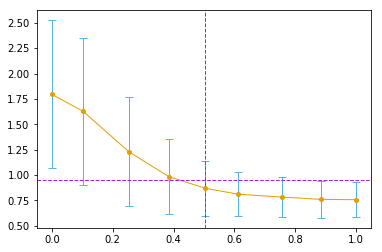

In [47]:
plt.plot(shrinkage, lo_errs, c=ORANGE, linewidth=1)
plt.errorbar(shrinkage, lo_errs,
             color=ORANGE, linestyle='None', marker='o', elinewidth=1,
             markersize=4, yerr=lo_stde, ecolor=BLUE, capsize=4)
plt.axhline(y=min_err+min_err_stde, c=PURPLE, linewidth=1, linestyle='--')
plt.axvline(x=shrinkage[selected_index], c=PURPLE, linewidth=1, linestyle='--')

In [58]:
selected_index = 3
lo = Lasso(alpha=parameters['alpha'][selected_index]).fit(X_train, y_train)

In [59]:
lo_error_rate = mean_squared_error(np.squeeze(y_test), 
                                   lo.predict(X_test))
lo_std_error = lo_stde[selected_index]
np.hstack((lo.intercept_, lo.coef_))
print(f'Lasso MSE: {lo_error_rate:.3f}')
print(f'Lasso Std Error: {lo_std_error:.3f}')

Lasso MSE: 0.474
Lasso Std Error: 0.367
